<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/GNN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download datasets

In [10]:
!pip install dgl

from datetime import date
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx
import astropy.io.ascii
import torch.nn as nn
import torch.nn.functional as F
from os.path import basename

import matplotlib.pyplot as plt

# if not torch.cuda.is_available():
#     raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type')
device = torch.device('cpu')

!wget -O data.zip https://github.com/erezimm/ML-ML/raw/master/data.zip
!unzip -o -q data.zip -d ./data
training_path = '/content/data/training_set'
validation_path = '/content/data/validation_set'

--2020-08-05 13:16:37--  https://github.com/erezimm/ML-ML/raw/master/data.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip [following]
--2020-08-05 13:16:37--  https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59777 (58K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  58.38K  --.-KB/s    in 0.007s  

2020-08-05 13:16:37 (7.73 MB/s) - ‘data.zip’ saved [59777/59777]



## Class CustomDataset loads all files and converts them to a list of graphs

Each node in a graph is a data point, i.e. node features are days since start, mag, magerr

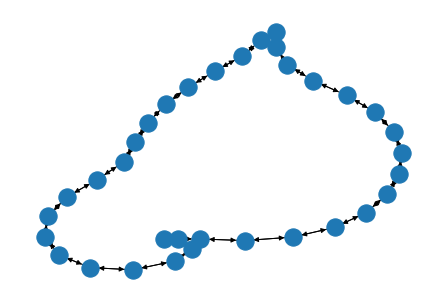

In [11]:
class CustomDataset(Dataset):
    def __init__(self, path):
        filelist = glob.glob(path+'/*')
        
        self.graphs = []
        self.isMicrolensed = []
        for fname in tqdm(filelist):
            filebasename = basename(fname)
            if filebasename.startswith('clean'):
                microlensed = torch.tensor([0])
            elif filebasename.startswith('microlensed'):
                microlensed = torch.tensor([1])
            else:
                raise Exception('Filename ' + fname + ' not clean_*/microlensed_*')
            
            with open(fname) as f:
                data = astropy.io.ascii.read(f.read())
                times, mags, magerrs = data['col1'], [], data['col3']
                for m, err in zip(data['col2'], magerrs):
                    mags.append(round(m, len(str(err).split('.')[1])))
                    # print(m, err, mags[-1])
                zipped = list(zip(times, mags, magerrs))
                zipped.sort(key=lambda tup: tup[0])
                times, mags, magerrs = zip(*zipped)

                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(mags).float()
                g.ndata['magerr'] = torch.tensor(magerrs).float()
                g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                
                self.graphs.append(g)
                self.isMicrolensed.append(microlensed)
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]


train_ds = CustomDataset(training_path)
# validation_ds = CustomDataset(validation_path)

nx.draw(dgl.to_networkx(train_ds[20][0]))

In [12]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['time', 'mag', 'magerr'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

## The Newtwork

In [30]:
n_ft = 3  # number of node features (time, mag, magerr)

class EdgeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(EdgeNetwork, self).__init__()
        n_in = 2*(n_ft + node_hidrep)
        
        # params:
        sizes = [n_in] + [] + [edge_hidrep]  # edit middle list, can be empty

        # create networks:
        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        #your input x is an object with the following properties:
        # x.dst['node_features'], x.dst['node_hidden_state']
        # x.src['node_features'], x.src['node_hidden_state']
        # x.data['distance']
        
        #put them together with torch.cat

        print( x.dst['time'].shape, x.dst['mag'].shape, x.dst['magerr'].shape, x.dst['node_hidrep'].shape,
                x.src['time'].shape, x.src['mag'].shape, x.src['magerr'].shape, x.src['node_hidrep'].shape )

        input = torch.cat(( x.dst['time'], x.dst['mag'], x.dst['magerr'], x.dst['node_hidrep'],
                            x.src['time'], x.src['mag'], x.src['magerr'], x.src['node_hidrep'] ), dim=1)
        
        #use a neural network to create an edge hidden represetation - 

        output = self.network(input)

        #you return a dictionary with what you want to "send" to the reciving node
        return {'edge_hidrep': output }

    
class NodeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(NodeNetwork, self).__init__()
        n_in = 2*edge_hidrep + node_hidrep + n_ft

        # params:
        sizes = [n_in] + [] + [node_hidrep]  # edit middle list, can be empty

        # create networks:
        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        input = torch.mean( x.mailbox['edge_hidrep'] , dim=1 )

        # print( mb.shape, x.data['node_hidden_state'].shape, x.data['node_features'].shape )

        input = torch.cat((mb, x.data['node_hidrep'], x.data['time'], x.data['mag'], x.data['magerr']), dim=1)
        out = self.network(input)

        # return a new hidden state for the node
        return {'node_hidrep': out }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # params:
        node_hidrep, edge_hidrep = 10, 10
        sizes_nodeinit = [n_ft] + [] + [node_hidrep]  # edit middle list, can be empty
        self.update_loop_length = 20

        # create networks:
        layers = []
        for i in range(len(sizes_nodeinit)-1):
            layers.extend([nn.Linear(sizes_nodeinit[i], sizes_nodeinit[i+1]), nn.ReLU()])
        self.node_init = nn.Sequential(*layers)
        self.edge_network = EdgeNetwork(node_hidrep, edge_hidrep)
        self.node_network = NodeNetwork(node_hidrep, edge_hidrep)
        
    def forward(self, g):
        features = torch.tensor(list(zip(g.ndata['time'], g.ndata['mag'], g.ndata['magerr'])))
        print(features)
        g.ndata['node_hidrep'] = self.node_init(features)
        for i in range(self.update_loop_length):
            g.update_all(self.edge_network, self.node_network)
        
        out = 0
        for x in g.ndata['node_hidrep']:
            out = max(out, torch.sum(x))
        return out 

In [31]:
net = Classifier()
net.to(device)

Classifier(
  (node_init): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=26, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=33, out_features=10, bias=True)
      (1): ReLU()
    )
  )
)

## Train

In [32]:
loss_func = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [33]:
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate)

n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    net.train()
    losses = []
    for x,y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x)
        # print(output.shape, y.shape)
        loss = loss_func(output,y)
        losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    print(epoch, ':', np.mean(np.array(losses)))      

tensor([[5.8219e+04, 2.0333e+01, 1.7600e-01],
        [5.8219e+04, 2.0203e+01, 1.6400e-01],
        [5.8223e+04, 2.0533e+01, 1.9400e-01],
        ...,
        [5.8471e+04, 1.8127e+01, 5.6000e-02],
        [5.8474e+04, 1.8425e+01, 6.7000e-02],
        [5.8480e+04, 1.8418e+01, 5.8000e-02]])
torch.Size([1840]) torch.Size([1840]) torch.Size([1840]) torch.Size([1840, 10]) torch.Size([1840]) torch.Size([1840]) torch.Size([1840]) torch.Size([1840, 10])


IndexError: ignored

## Evaluate

Once you train your network you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,

train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [ ]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True, collate_fn=collate)

net.cpu()
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print('true positive: ', true_positive/total_positives)
print(false_negative/total_positives)
print('true negative: ', true_negative/total_negatives)
print(false_positive/total_negatives)

## Save
Don't forget to download

In [ ]:
torch.save(net.state_dict(), 'ML-ML/models/model.pt')